##### 15-388 Term Project, by Shangda Li (andrewID: shangdal), Yang Jin (andrewID: yangjin) and Xinhui Guo (andrewID: xinhuig).

# Data Science on Bitcoin Trading

# Introdunction

Bitcoin is a new and fast growing currency, and now there are several trading markets of Bitcoin. Compared with stocks, index funds and futures, Bitcoin market approximates a free market more, and is considered less complex to analyze. Thus, this project aims to apply Data Science on Bitcoin Trading, and build an automated Bitcoin trading algorithm that makes money on its own. Most importantly, we want to investigate the potential factors that influence the Bitcoin market, and unveil some characteristics of this market from the perspective of Data Science.

# Content In this Notebook
* **Getting Raw Data**
* **First Try**: Predict Price Using Linear Regression
* **Second Try**: Predict Existence of Higher Price using Linear Classification
* **Third Try**: Predict Trend of Price Using Linear Classification
* **Summary**: Application of Machine learning in Bitcoin Trending

In [5]:
import requests
import json
import numpy as np
import pandas as pd
import datetime as dtime
import pickle
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
plt.style.use("ggplot")

## Section 0: Getting Raw Data
We found the data from https://bitcoincharts.com/ (http://api.bitcoincharts.com/v1/csv/coinbaseUSD.csv.gz), which provides a huge CSV file around 500MB, that records all the historical transactions in the past two years. We did some preprocessing on the raw data we collect, and wrote the data into a file that makes it easier for later analysis.

In [2]:
filename = "data/coinbaseUSD.csv"
df = pd.read_csv(filename)
df['Time'] = df['Time'].apply(lambda x : dtime.datetime.fromtimestamp(float(x)))
df = df.groupby(['Time']).agg({'Price':'mean', 'Quantity':'sum'})
df.to_csv("processed.csv")

In [6]:
df = pd.read_csv("processed.csv")
# convert string to datetime
df['Time'] = pd.to_datetime(df['Time'])

One non-trivial thing we did above is merging transactions that happen almost together, because we don't need the exact time of every individual transaction up to milliseconds precision.

## Section 1: Predict Price Using Linear Regression
The first thing we tried is to use the most basic Linear Regression. For each sample, we look at the recent prices at several fixed data points (10 seconds before, 20s before, 30s before ... to 600s before), and the label is the max price in the next 90 seconds minus the current price. If an effective model for this data format exists, then we can build our automated trading algorithm on it.

In [7]:
lookback_seconds = 600 #data points are collected from lookback_seconds in the past to present
predict_seconds = 100 #time duration in the future to predict
train_interval = 10 #time in seconds of intervals between data points

def extract_x(current_time, dataframe):
    #time instances on which to get price data
    data_points = [i for i in range(train_interval,lookback_seconds+train_interval,train_interval)]
    
    lookback = dtime.timedelta(seconds = lookback_seconds)
    
    #position in dataframe of the time instance closest to current_time
    end_i = np.argmin(np.abs(dataframe['Time'] - current_time)) + 1
    #position in dataframe of the time instance closest to current_time-lookback
    start_i = np.argmin(np.abs(dataframe['Time'] - (current_time-lookback))) - 1
    
    #extract price data on this segment
    segment = dataframe.iloc[start_i:end_i]
    
    def time_to_float (x):
        return (current_time-x).total_seconds()
    
    result_prices = []
    
    x_list = segment['Time'].apply(time_to_float).tolist()[::-1]
    y_list = segment['Price'].tolist()[::-1]
    
    #use interpolation to get data on wanted time instances
    current_price = np.interp(0, x_list, y_list)
    for x in data_points:
        temp = np.interp(x, x_list, y_list)
        result_prices.append(temp - current_price)
        
    X = result_prices
    
    return (X, current_price)

In [8]:
def extract_y(current_time, dataframe):
    predict_interval = (0, predict_seconds)

    predict_interval = (current_time + dtime.timedelta(seconds=predict_interval[0]),
                        current_time + dtime.timedelta(seconds=predict_interval[1]))

    predict_slice = dataframe[(dataframe['Time'] >= predict_interval[0]) 
                                & (dataframe['Time'] <= predict_interval[1])]

    #no data available in future duration
    if predict_slice.shape[0] == 0:
        return None

    Y = np.max(predict_slice['Price'])
    return Y

In [9]:
def extract_feature(current_time, dataframe):
    X, current_price = extract_x(current_time, dataframe)
    Y = extract_y(current_time, dataframe)
    if Y == None:
        return None
    return (X, Y - current_price)
    
# test on a particular example
extract_feature(dtime.datetime(2016,5,20),df)

([0.046895424666672625,
  0.09379084933334525,
  0.12605228709998073,
  0.026607842766679823,
  -0.07283660156667793,
  -0.15935985726667923,
  -0.12959241526669985,
  -0.09982497326666362,
  0.019324528390484375,
  0.19806206981905916,
  0.3767996112475771,
  0.5372050651999984,
  0.5326217318666409,
  0.5280383985332833,
  0.5192050651999693,
  0.4721217318666504,
  0.4250383985333315,
  0.3798717318666718,
  0.3519550652000021,
  0.3240383985333324,
  0.3070383985333365,
  0.38828839853334784,
  0.46953839853330237,
  0.5424967318666631,
  0.540830065199998,
  0.5391633985333328,
  0.5376633985333115,
  0.5376633985333115,
  0.5376633985333115,
  0.5376633985333115,
  0.5376633985333115,
  0.5376633985333115,
  0.5380205413904378,
  0.5415919699618712,
  0.5451633985333046,
  0.5776633985333319,
  0.6776633985332978,
  0.7776633985333206,
  0.35980174233975504,
  0.5849264513720414,
  0.8100511604042708,
  1.0126633985333342,
  1.0126633985333342,
  1.0126633985333342,
  1.011163398

Given this helper function that extracts feature for a particular time, we wrote a program that procedurely generates our training set, specified by the time interval and the dataframe we pass as parameters.

In [10]:
def prepare_samples(start_time, end_time, dataframe):
    delta_seconds = 30
    
    scope_x = start_time - dtime.timedelta(minutes = 30)
    scope_y = end_time + dtime.timedelta(minutes = 30)
    
    scope = dataframe[(dataframe['Time'] > scope_x) 
                             & (dataframe['Time'] < scope_y)].reset_index(drop=True)
    
    pointer = start_time
    
    X = []
    Y = []
    while pointer < end_time:
        temp = extract_feature(pointer, scope)
        if temp is not None:
            X.append(temp[0])
            Y.append(temp[1])
        pointer = pointer + dtime.timedelta(seconds = delta_seconds)
    
    return (X,Y)

Generate a particular training set:

In [11]:
samples = prepare_samples(dtime.datetime(2016,5,20), dtime.datetime(2016,5,21), df)

Let's visualize our data using a few typical examples extracted from KMeans.

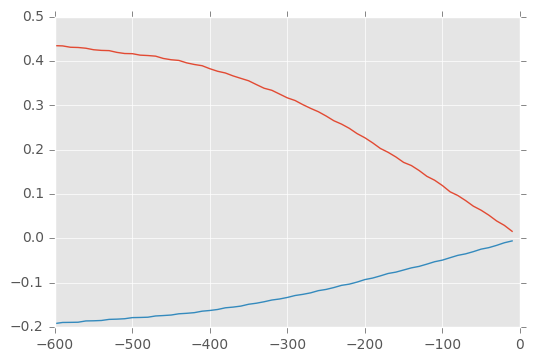

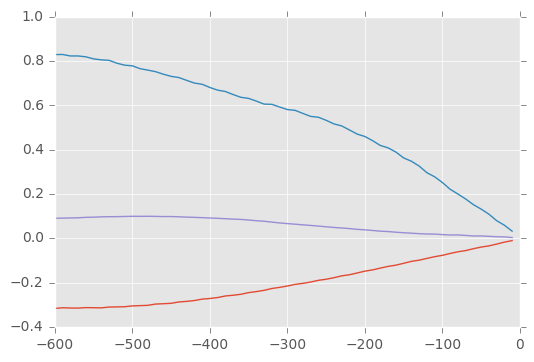

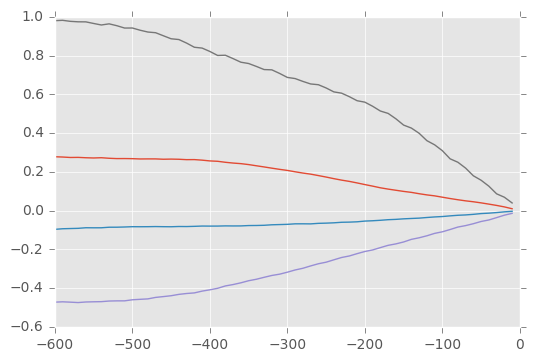

In [13]:
for n_clusters in range (2, 5):
    centers = KMeans(n_clusters=n_clusters).fit(samples[0]).cluster_centers_

    x = [(0-i) for i in range(train_interval, lookback_seconds+train_interval, train_interval)]

    for i in range(0, n_clusters):
        plt.plot(x, centers[i])
    plt.show()

As we can see, the plots of typical samples follow general patterns of either decreasing or increasing. Now, let's see how well a Linear Regression model can be trained on this data.

In [14]:
reg = linear_model.LinearRegression(normalize=True)

In [15]:
reg.fit(samples[0], samples[1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [16]:
reg.score(samples[0], samples[1])

0.055986718586553574

The score above indicates the coefficient of determination R^2 of the prediction. Such score is a "terrible" score, which means the proportion of the variance in the dependent variable that is predictable from the independent variable, so we think the prediction of an exact price change might be too hard. Perhaps training a binary classification SVM that predicts whether there is a chance of making money in the next 90 seconds would be more accurate. This is our immediate next step.

## Section 2: Predict Existence of Higher Price using Linear Classification

In [18]:
def cutoff(s):
    '''
    use binary search to determine a price cutoff that
    splits data into two sets of the same size
    '''
    profit_min = 0.0
    profit_max = 1.0
    num_sample = len(s[1])
    while profit_max > profit_min:
        profit = (profit_max + profit_min) / 2
        profit_count = sum(i > profit for i in s[1])
        profit_precentage = float(profit_count) / num_sample
        
        if abs(profit_precentage-0.5) < 0.01:
            profit = profit_min
            break
        if profit_precentage > 0.5:
            profit_min = profit
        else:
            profit_max = profit
    return profit

def sample_for_svm(s, profit):
    newY = []
    for x in s[1]:
        if x >= profit:
            newY.append(1)
        else:
            newY.append(0)
    print float(sum(i > profit for i in s[1])) / len(s[1]), "is the percentage classified as 1"
    print profit, "is our price cutoff"
    return (s[0], newY)

We split the data into two sets of equal sizes because, imagine if we choose a price cutoff that labels most samples as 0. Then a dummy classifier could just classify every sample as 0 and achieve a percentage of greater than 50 percent. For instance: let's say we choose a price cutoff at 0.1:

In [19]:
svm_sample = sample_for_svm(samples, 0.1)
clf = SVC()
clf.fit(svm_sample[0], svm_sample[1])
print clf.score(svm_sample[0], svm_sample[1]), "is the score"

0.305874174487 is the percentage classified as 1
0.1 is our price cutoff
0.69516857838 is the score


On a first look, 0.69516857838025725 seems a high percentage. But on a closer look, 0.69516857838025725 + 0.305874174487 is just 1. Could the SVM classified every thing as 0? Let's test it out.

In [20]:
def print_percentage_one(clf, x):
    total_zero = 0.0
    cnt = 0
    for i in x:
        total_zero += clf.predict([i])[0]
    print total_zero / len(x), "percent classified as 1"

In [21]:
print_percentage_one(clf, svm_sample[0])

0.00104275286757 percent classified as 1


As we suspected, the dummy svm classified almost everything as 0. Now let's try splitting up the data.

In [22]:
svm_sample = sample_for_svm(samples, cutoff(samples))
clf = SVC()
clf.fit(svm_sample[0], svm_sample[1])
print clf.score(svm_sample[0], svm_sample[1])
print_percentage_one(clf, svm_sample[0])

0.568300312826 is the percentage classified as 1
0.03125 is our price cutoff
0.568647897115
1.0 percent classified as 1


Well splitting the data doesn't help at all. SVM classified everything as 1 this time. Maybe there's something wrong with the default parameters of SVM. Let's try grid search to see if we could increase its performance.

In [23]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
second_clf = GridSearchCV(clf, parameters)
second_clf.fit(svm_sample[0], svm_sample[1])
print second_clf.score(svm_sample[0], svm_sample[1]), "is the score"
print_percentage_one(second_clf, svm_sample[0])

0.568647897115 is the score
1.0 percent classified as 1


That still doesn't change anything. SVM is still classifying everything as 1. Therefore SVM is probably not the way to go here. So instead of using a simple linear hypothesis, we probably need something more complicated. Could a gradient boosting classifier be more useful?

In [24]:
gbrt = GradientBoostingClassifier()
gbrt.fit(svm_sample[0], svm_sample[1])
print gbrt.score(svm_sample[0], svm_sample[1])
print_percentage_one(gbrt, svm_sample[0])

0.790754257908
0.638859923531 percent classified as 1


Well that seems a lot more encouraging. Let's test it with data from other days to see its performance.

In [25]:
def test_estimator(est, start, end, data, price_cutoff):
    samples = prepare_samples(start, end, data)
    test = sample_for_svm(samples, price_cutoff)
    return est.score(test[0], test[1])

In [26]:
print test_estimator(gbrt,dtime.datetime(2016,7,2),dtime.datetime(2016,7,3),df, 0.03125)

0.485484435117 is the percentage classified as 1
0.03125 is our price cutoff
0.597411682406


That's almost 60 percent. Now with a trained classifier, let's try it on a few plotted samples to see if the decisions made by the classifier make sense.

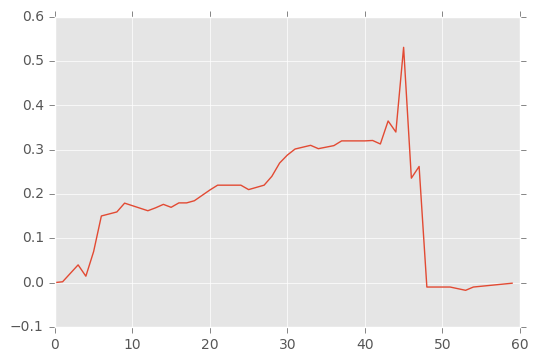

increase


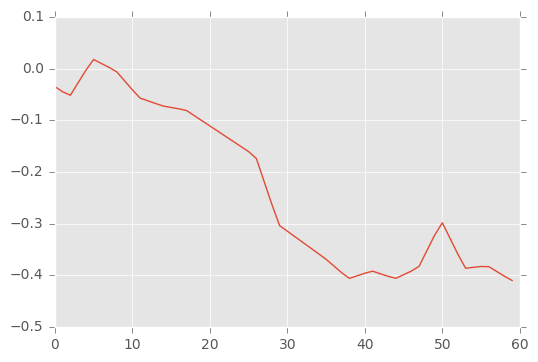

decrease


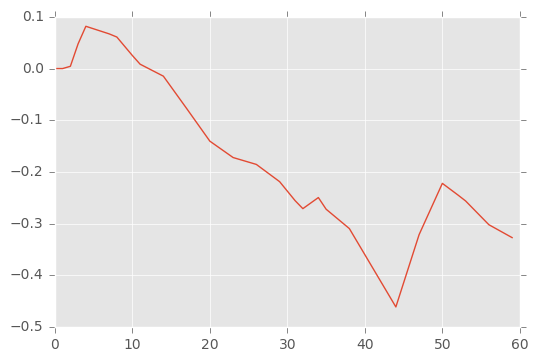

increase


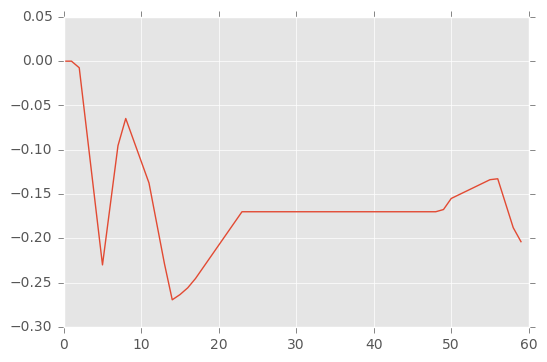

decrease


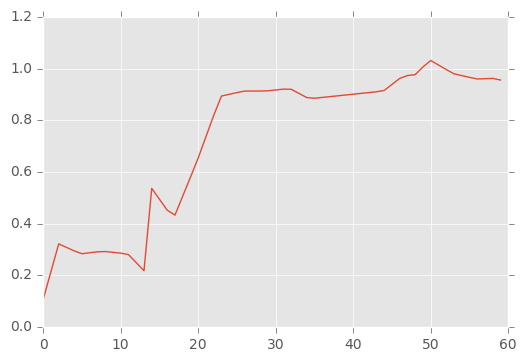

increase


In [27]:
def validate(estimator, dataframe, start_time):
    x, price = extract_x(start_time, dataframe)
    plt.plot(x)
    plt.show()
    if estimator.predict([x])[0] == 1:
        print "increase"
    else:
        print "decrease"

for i in range(1, 6):
    validate(gbrt, df, dtime.datetime(2016,i,4))

It seems that the classifier is making reasonable decisions at this point. Let's use a simulator to test its performance. The simulator will start with 100 dollars and buy everything or sell everything every period of time depending on the decision made by our classifier.

In [28]:
def simulate(estimator, dataframe, start_time, duration, frequency, capital):
    lookback = dtime.timedelta(seconds = lookback_seconds)
    
    start_i = np.argmin(np.abs(dataframe['Time'] - (start_time-lookback))) - 1
    end_i = np.argmin(np.abs(dataframe['Time'] - (start_time+duration))) + 1
    
    duration_seconds = int(duration.total_seconds())
    
    def time_to_float (x):
        return (x - start_time).total_seconds()
    
    seg = dataframe.iloc[start_i:end_i]
    seg_time = seg['Time'].apply(time_to_float).tolist()
    seg_price = seg['Price'].tolist()

    data_time = range(-lookback_seconds, duration_seconds+1, train_interval)
    sim_data = [np.interp(time, seg_time, seg_price) for time in data_time]
    
    dimension = lookback_seconds / train_interval
    step = frequency / train_interval
    
    bought = False
    bought_price = 0.0
    time_since_bought = 0.0

    for i in range(dimension, len(sim_data), step):
        x = []
        current_price = sim_data[i]
        for price in sim_data[i-dimension:i]:
            x.append(price-current_price)
        decision = estimator.predict(np.asarray(x).reshape(1,-1))[0]

        if (decision == 1 and not bought):
            bought = True
            bought_price = sim_data[i]
        elif (decision == 0 and bought):
            bought = False
            capital = capital * sim_data[i] / bought_price
            
    return capital

print simulate(gbrt, df, dtime.datetime(2016,2,6), dtime.timedelta(seconds = 3600), 20, 100)

99.517328809


This doesn't seem impressive since we actually lost money. But the accurency of our prediction is almost 60%, why are we losing money? After analyzing the situation, we found two possible reasons: First, we have an unbalanced data between the two labels that we assigned. As we conclude from generating training dataset from many different time periods, on average there is only a 25% chance of seeing such an opportunity (seeing a price 0.1 USD more than the current price per bitcoin). That is, 75% data are labeled as 0 and 25% are 1. Consider a "dummy" algorithm that always output 0, then such a "dummy" algorithm can have a 75% accuracy, so the fact our ML classifier has around 80% accuracy (which intuitively sounds really good) has little significance. 

Moreover, even though some classifier may have a really good accuracy of classifiying such feature, say 90%, the corresponding trading strategy still might not be able to earn money, because in the case of that 10% wrong classifications, which tend to be the most extreme cases so that our classifier finds it unable to classify, we may lose a lot of money, much more than 0.1 USD per bitcoin. 

## Section 2: Predict Trend of Price Using Linear Classification

Here comes the motivation of classifying trend instead of classifying the existence of profit opportunity. First, let's define some helper functions for doing this:

In [29]:
# given a start time and an end time, this function returns a segment from the dataset (ordered by timestamp) 
# that contains sufficient data for this time interval

def get_sufficient_data(starttime, endtime, dataframe):
    end_i = np.argmin(np.abs(dataframe['Time'] - endtime)) + 1 # offset by the next one
    start_i = np.argmin(np.abs(dataframe['Time'] - (starttime))) - 1 # offset by the previous one
    segment = dataframe.iloc[start_i:end_i]
    segment = segment.reset_index(drop=True)
    return segment

In [30]:
# create an Interpolation instance that will be able to interpolate (linearly) the price for any time within the time interval
# specified by the dataframe that you initialize the instance with.
# This function is necessay because our dataset contains price data at discrete times, yet our algorithm runs in a
# continuous manner (say, run every 20 seconds)

class Interpolation:
    
    def time_to_float (self, x):
        return (x - self.origin).total_seconds()
    
    def __init__(self, data):
        self.origin = data['Time'].min()
        self.x_list = np.array(data['Time'].apply(self.time_to_float).tolist())
        self.y_list = np.array(data['Price'].tolist())
    
    # interpolate the price
    def fetch(self, sometime):
        return np.interp(self.time_to_float(sometime), self.x_list, self.y_list)
    
    # return the time difference between the current time and the nearest time in our dataset
    def error(self, sometime):
        formattime = self.time_to_float(sometime)
        idx = (np.abs(self.x_list-formattime)).argmin()
        return np.abs(self.x_list[idx]-formattime)

The following function is used to create features for prediction. After some trail-and-error, it turns out that extracting the price data at every 15 seconds in the past 30 minuts would be sufficiently powerful for predicting the trend in the next 2 minutes.

In [31]:
# Given a time and an Interpolation instance, return the historical data as well as the current price for the time.
# return (history, currentprice)

def extract_history_and_price (currenttime, interp):
    
    # define the time points of looking back (in terms of seconds) for feature, in total, 120 features. 
    data_points = [i for i in range(15,1815,15)] 
    
    # define a threshold (in terms of seconds) for a good sample 
    # -- each time point can be relatively accurately interpolated
    accuracy = 60
    
    result = []
    
    if(interp.error(currenttime) > accuracy):
        return None
    
    currentprice = interp.fetch(currenttime)
    
    for p in data_points:
        time = currenttime - dtime.timedelta(seconds = p)
        if(interp.error(time) > accuracy):
            return None
        result.append(interp.fetch(time) - currentprice)
    
    return (result, currentprice)

The function above outputs the X for each time, which is our feature. Now we need to consider the Y, which gives us the signal whether we should buy bitcoin or cash bitcoin. What would be a good indicator of the trend in the near future?

Our short-term trend is defined to be the difference between the current price and the average price in the next 90 seconds. If the current price is lower than the average price in the next 90 seconds, then it should be considered as an upward trend, so the function returns 1. Otherwise, it should be a downward trend, and the function returns 0.

In [32]:
# Return 1 or 0. If there is insufficient data, then return None

def predict_trend (currenttime, currentprice, dataframe):
    
    # prediction interval
    interval = (0, 90)
    
    
    interval = (currenttime + dtime.timedelta(seconds = interval[0]),
                  currenttime + dtime.timedelta(seconds = interval[1]))
   
    myslice = dataframe[(dataframe['Time'] >= interval[0]) 
                                & (dataframe['Time'] <= interval[1])]
 
    # too little data
    if myslice.shape[0] == 0:
        return None
    
    mean = np.mean(myslice['Price'])
    
    # judge the trend
    if currentprice < mean:
        return 1
    return 0

The following function creates training dataset, specified by the time interval and how frequently it should extract a sample. It prints out the count of data that labeled 0 versus the count of those labeled 1. It returns a tuple, where the first element is a list of features, the historical data points in the past 30 minuts (X), for each sample, and the second element is a list of the corresponding trend (Y).

In [33]:
def create_training_set(starttime, endtime, dataframe, delta):
    
    dataframe = get_sufficient_data(starttime,endtime,dataframe)
    
    interp = Interpolation(dataframe)
    
    result_X = []
    result_Y = []
    
    pointer = starttime
    
    cnt_one = 0
    cnt_zero = 0
    
    while pointer < endtime:
        
        history = extract_history_and_price(pointer, interp)
        
        if history is not None:
            x, currentprice = history
            y = predict_trend(pointer, currentprice, dataframe)
            
            if y is not None:
                result_X.append(x)
                result_Y.append(y)
                if y == 1:
                    cnt_one = cnt_one + 1
                else:
                    cnt_zero = cnt_zero + 1
      
        pointer = pointer + delta
    
    
    print "Count of Sample = 1: " + str(cnt_one)
    print "Count of Sample = 0: " + str(cnt_zero)
    
    return (result_X, result_Y)

Let's create a dataset. The data spans three days.

In [34]:
data = create_training_set(dtime.datetime(2016,5,20),dtime.datetime(2016,5,23),df,dtime.timedelta(seconds = 20))

Count of Sample = 1: 5782
Count of Sample = 0: 5159


It should take less than 5 minutes and print: <Br>
Count of Sample = 1: 5782 <Br>
Count of Sample = 0: 5159 <Br>

We can see the data is pretty balanced between label 1 (upward trend) and label 0 (downward trend).

It would be very intersting to see how the data labeled as 1 are different from those labeled as 0. So we write the following function that splits the data by their label.

In [36]:
def datasplit(training_set):
    One = []
    Zero = []
    for i in range(0, len(training_set[0])):
        if training_set[1][i] == 1:
            One.append(training_set[0][i])
        else:
            Zero.append(training_set[0][i])
    
    return (One, Zero)

In [37]:
(One, Zero) = datasplit(data)

Run KMeans algorithm to visualize the cluster of each label.

In [38]:
kmeans = KMeans(n_clusters=1, random_state=0)

# helper variable for visualization
x_axis = [(0 - i) for i in range(15,1815,15)]

# helper function for run KMeans and visualize the clusters
def see_clusters(data, n_cluster):
    
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(data)
    
    for cluster in kmeans.cluster_centers_:
        plt.plot(x_axis, cluster)
    
    plt.show()

For Label 1, for an upward trend to happen, the historical data on average looks like:

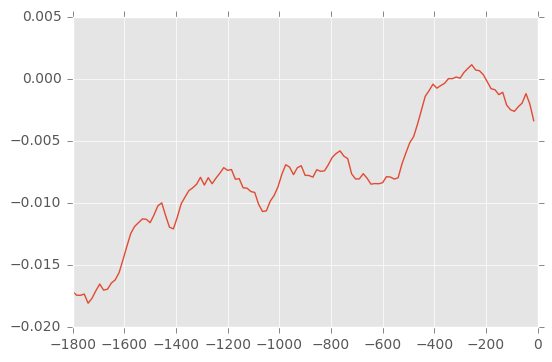

In [39]:
see_clusters(One, 1)

For Label 0, for a downlard trend to happen, the historical data on average looks like:

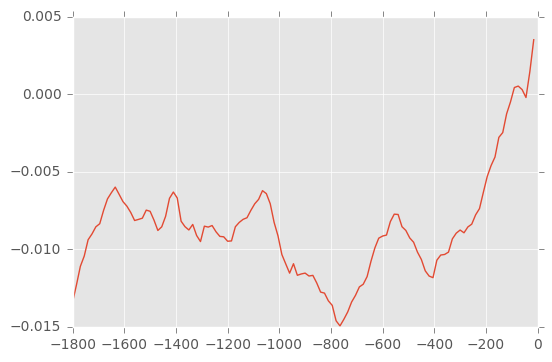

In [40]:
see_clusters(Zero, 1)

I think the contrast above is pretty intuitivie, in that, if the price suddenly goes up, then it tends to go down, where as if the general trend progressively goes up, and at some point it goes down a little bit, then it tends to go up again.

We can compare them in terms of more clusters, as below:

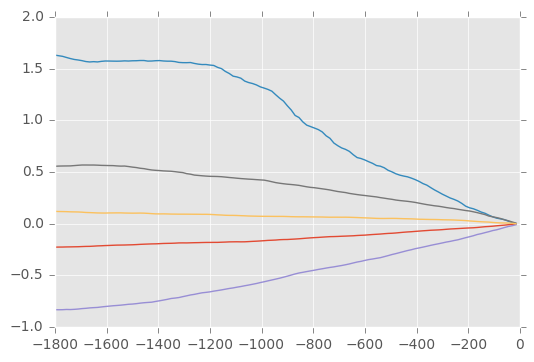

In [41]:
# for upward trend to happen, the historical data looks like:
see_clusters(One, 5)

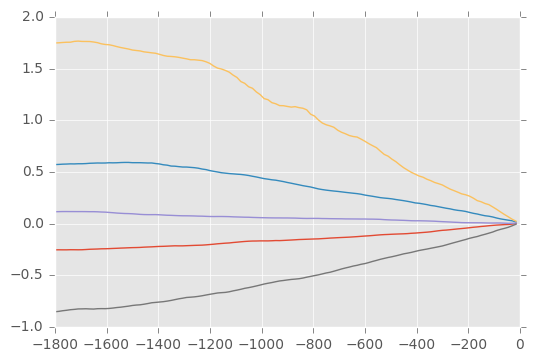

In [42]:
# for downward trend to happen, the historical data looks like:
see_clusters(Zero, 5)

They look pretty much the same, which implies that the trend of the price is very hard to be predicted solely from the historical price data.

We choose the Gradient Boosting Decision Tree as our classifier, after some trial-and-error (SVM performs horribly as explained in the previous section). The first step is to use Cross-Validation and Grid-Search to determine the best hyperparameter for our classifier, so as to prevent over-fit and still achieve optimal accuracy on the training set.

In [43]:
gbrt = GradientBoostingClassifier()

# Grid Seach by Cross Validation
parameters = {'max_depth':[1,2,3], 'n_estimators':[100,200,300]}
clf = GridSearchCV(gbrt, parameters, verbose=True)
clf.fit(data[0], data[1])

gbrt = clf.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.9min finished


After achieving the best estimator setting, we train our estimator by our training dataset.

In [44]:
gbrt.fit(data[0], data[1])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

How well does it perform on the training set it self?

In [45]:
gbrt.score(data[0], data[1])

0.62837035005940955

This doesn't seem like a good score, which implies it is very hard to generalize some patterns from the historical price data to predict the future trend. However, it is still much better than flipping a coin.

Now comes the exciting part!!! We are going to write a simulation program that trade bitcoin on its own, provided the estimator we trained for predicting the future trend. We will finally investiaget whether we can make money from this algorithm or not.

The following function takes in the time interval we want to simulate, the frequency we want the algorithm to run and predict the trend, the money we start with (in USD), and the estimator we just trained.

In [46]:
# output the USD we have after automated trading in the given time interval

def simulation(startime, duration, delta, money, data, estimator):
    
    po = startime
    
    padding = dtime.timedelta(hours = 1)
    
    endtime = startime + duration
    
    data = (get_sufficient_data(startime - padding, endtime + padding, data))
    
    realdata = Interpolation(data)
    
    usd = money
    coin = 0
    
    lastusd = money
    
    # start running the automated trading routine
    while po < endtime:
        
        # extract the feature at this moment
        history = extract_history_and_price(po, realdata)
        
        if history is not None:
            x, currentprice = history
            
            # predict the trend
            prediction = estimator.predict([x])
            
            # if the price will go down, and we bear Bitcoin right now, sell the Bitcoin
            if prediction == [0] and usd == 0:
                usd = coin * currentprice
                
                # record the usd we have from the last round of trade
                lastusd = usd
                coin = 0
            
            # if the price will go up, and we bear USD right now, buy Bitcoin
            elif prediction == [1] and coin == 0:
                coin = usd / currentprice
                usd = 0
                
        po = po + delta
        
    return lastusd

We train our estimator using the data from 2016-5-20 to 2016-5-23. We are going to run a simulation that lasts 80 hours, starting from 2016-5-25 5 a.m., therefore, it would be a resonable simulation that reflects the performance of the automated trading algorithm, as it uses the recently trained estimator for the near future price data.

In [47]:
# We start with $100 USD, and we run the algorithm every 10 seconds
simulation(dtime.datetime(2016,5,25,5), dtime.timedelta(hours = 80), dtime.timedelta(seconds = 10), 100, df, gbrt)

121.9881585179566

The above line of code should run around 10 minuts and output the following: <Br>
    121.9881585179566
    
This number is fantastic, because it earns almost 22 dollars profit given 100 dollars as the base capital. To make sure it is our algorithm that helps us earn the money, I write a dummy simulation which determines the trend just by flipping a coin.

In [48]:
def simulation_by_flipping_coin(startime, duration, delta, money, data):
    
    po = startime
    
    padding = dtime.timedelta(hours = 1)
    
    endtime = startime + duration
    
    data = (get_sufficient_data(startime - padding, endtime + padding, data))
    
    realdata = Interpolation(data)
    
    usd = money
    coin = 0
    
    lastusd = money
    
    while po < endtime:
        
        # flip a coin to determine the trend
        currentprice = realdata.fetch(po)
        prediction = [random.randint(0, 1)]
        
        if prediction == [0] and usd == 0:
            usd = coin * currentprice
            lastusd = usd
            coin = 0
        elif prediction == [1] and coin == 0:
            coin = usd / currentprice
            usd = 0
                
        po = po + delta
        
    return lastusd

In [52]:
(simulation_by_flipping_coin
(dtime.datetime(2016,5,25,5), dtime.timedelta(hours = 80), dtime.timedelta(seconds = 10), 100, df))

105.07096505976921

Running this simulation with the same time interval and the same setting will give you a number from 102 to 107, which is much less than what we have --- 121.9881585179566! Even though the simulation is far from realistic (it assumes that we can always buy and sell Bitcoin at the interpolated price and it assumes no transaction fee nor transaction delay), it marks a success of our data science application on this topic.

## Summary: Application of Machine Learning in Bitcoin Trading
In this project, we tried three different approaches to optimize bitcoin trading using machine learning methods. Our first try was to predict exact future price using linear regression, but the accuracy turns out to be pretty low. Then we turned to predict if there's a chance to earn money, that is, we classified the pricing data according to if the maximum of future price would be higher than current data. Our classification performed pretty well in predicting opportunity to win money, however, after running simulation, it turns out that we lost money because the accuracy of our prediction is not as high as it looks because the probability of losing money is much higher than earning money. Then we moved on to predict the trend of price change. To be more specific, we increase bitcoin holding if we see an increasing trend in future price, and decrease bitcoin holding otherwise. Grandiant Boosting Classifier gave us a decent prediction, and after running simulation, our trading algorithm outperformed a lot than flipping coins. That is to say, machine learning algorithms can to some extent predict the future trend of bitcoin price, and can possibly help earn money. However, there are some factors we did not take into account when designing trending algorithms, like transcation fee and demand supply relationship.

In future research, we plan to optimize our trending algorithm by taking into account more features, like block size, trade volumn, total bitcoins, transcation to trade ratio to improve the accuracy of our prediction. 